In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv('/content/news.csv')
data.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [ ]:
data.shape


(6335, 4)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6335 non-null   int64 
 1   title       6335 non-null   object
 2   text        6335 non-null   object
 3   label       6335 non-null   object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB


In [ ]:
data= data.drop(['Unnamed: 0'], axis=1)
data.head()

,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [ ]:
data = data.drop(["title"], axis = 1)
data.head()



,text,label
0,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,It's primary day in New York and front-runners...,REAL


In [ ]:
data['label'].replace('FAKE', 0 , inplace = True)
data['label'].replace('REAL', 1 ,inplace = True)
data.tail()

,text,label
6330,While You Were Watching the World Series Some ...,0
6331,You Are Here: Home » Health & Wellness » 4 Mot...,0
6332,Here's something interesting from The Unz Revi...,0
6333,Has it come to this? We’re now begging Elizabe...,1
6334,Many people believe that there has been a wave...,0


In [ ]:
data.isnull().sum()


text     0
label    0
dtype: int64

In [ ]:
# Shuffling
data = data.sample(frac=1)
data.reset_index(inplace=True)
data.drop(["index"], axis=1, inplace=True)
data.head()


,text,label
0,The top Democrat on the Senate Intelligence Co...,1
1,Cast Your Vote: Whose Foreign Policy Position ...,0
2,"Email \nIn Drowning in a Sea of Microwaves , t...",0
3,"on November 13, 2016 3:09 pm · \nAs predicted,...",0
4,It is endlessly suspicious when politicians co...,1


In [ ]:
from tqdm import tqdm
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def preprocess_text(text_data):
	preprocessed_text = []

	for sentence in tqdm(text_data):
		sentence = re.sub(r'[^\w\s]', '', sentence)
		preprocessed_text.append(' '.join(token.lower()
								for token in str(sentence).split()
								if token not in stopwords.words('english')))

	return preprocessed_text


In [ ]:
preprocessed_review = preprocess_text(data['text'].values)
data['text'] = preprocessed_review


100%|██████████| 6335/6335 [10:20<00:00, 10.20it/s]


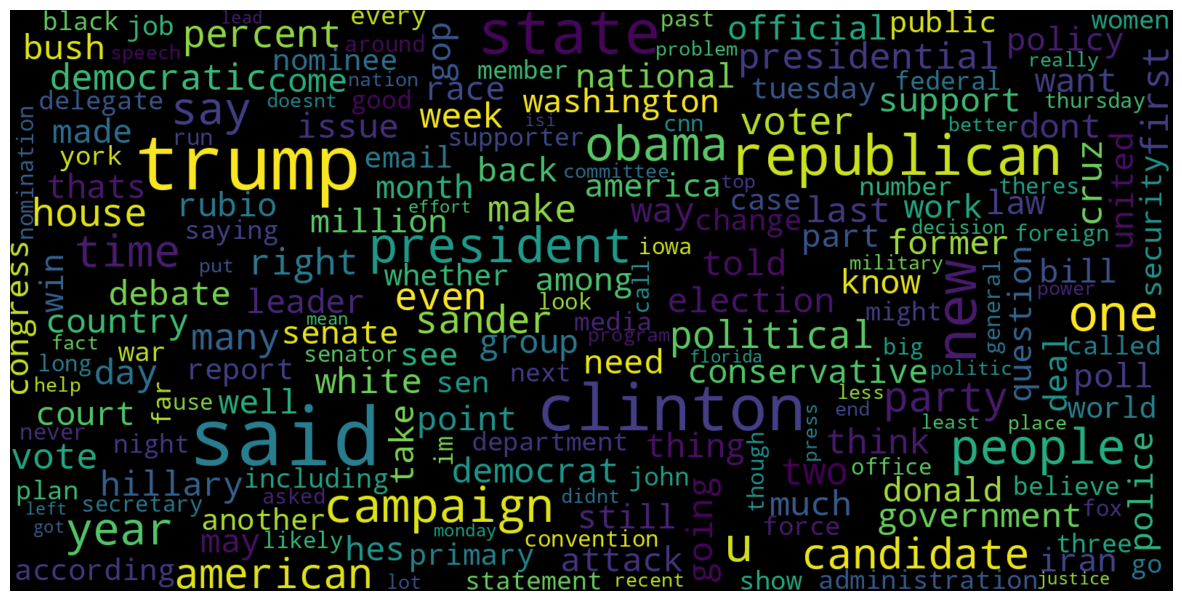

In [ ]:
# Real
consolidated = ' '.join(
	word for word in data['text'][data['label'] == 1].astype(str))
wordCloud = WordCloud(width=1600,
					height=800,
					random_state=21,
					max_font_size=110,
					collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()


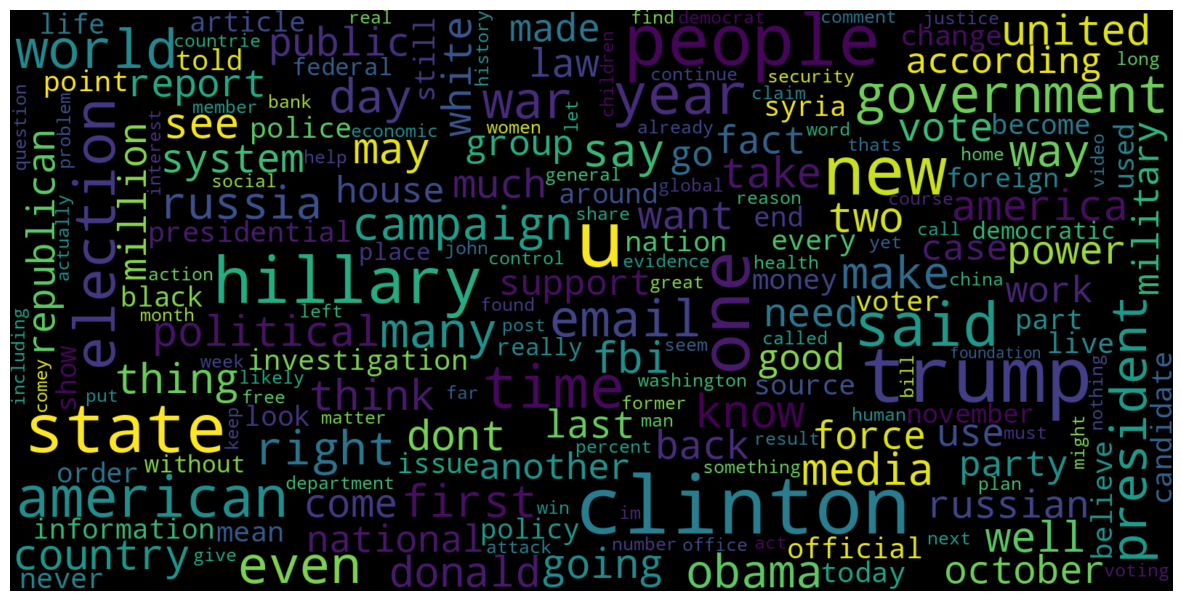

In [ ]:
# Fake
consolidated = ' '.join(
	word for word in data['text'][data['label'] == 0].astype(str))
wordCloud = WordCloud(width=1600,
					height=800,
					random_state=21,
					max_font_size=110,
					collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()


<Axes: title={'center': 'Bar Chart of Top Words Frequency'}, xlabel='Top Words', ylabel='Count'>

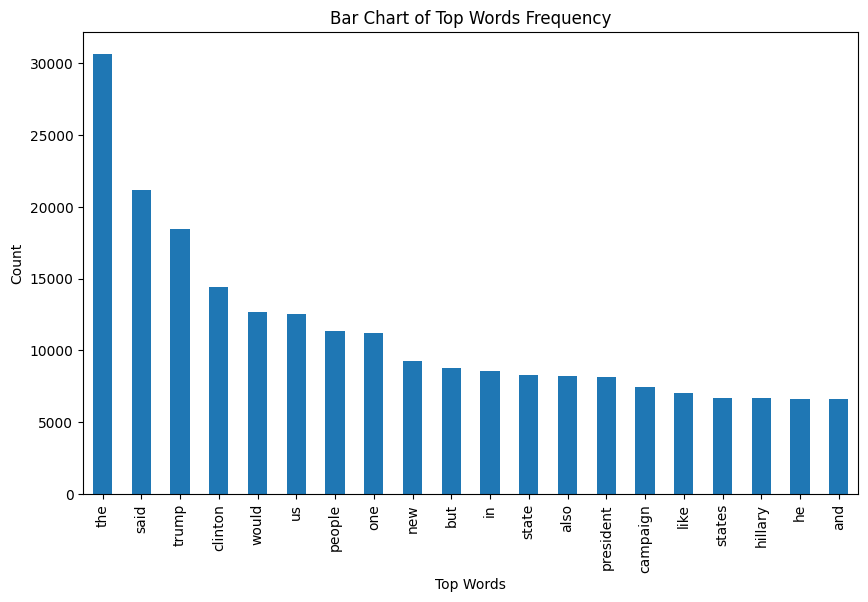

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer


def get_top_n_words(corpus, n=None):
	vec = CountVectorizer().fit(corpus)
	bag_of_words = vec.transform(corpus)
	sum_words = bag_of_words.sum(axis=0)
	words_freq = [(word, sum_words[0, idx])
				for word, idx in vec.vocabulary_.items()]
	words_freq = sorted(words_freq, key=lambda x: x[1],
						reverse=True)
	return words_freq[:n]


common_words = get_top_n_words(data['text'], 20)
df1 = pd.DataFrame(common_words, columns=['Review', 'count'])

df1.groupby('Review').sum()['count'].sort_values(ascending=False).plot(
	kind='bar',
	figsize=(10, 6),
	xlabel="Top Words",
	ylabel="Count",
	title="Bar Chart of Top Words Frequency"
)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

x_train, x_test, y_train, y_test = train_test_split(data['text'],
													data['label'],
													test_size=0.25)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorization = TfidfVectorizer()
x_train = vectorization.fit_transform(x_train)
x_test = vectorization.transform(x_test)


In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(x_train, y_train)

# testing the model
print(accuracy_score(y_train, model.predict(x_train)))
print(accuracy_score(y_test, model.predict(x_test)))


0.9585350452536309
0.9191919191919192


In [ ]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(x_train, y_train)

# testing the model
print(accuracy_score(y_train, model.predict(x_train)))
print(accuracy_score(y_test, model.predict(x_test)))


1.0
0.8068181818181818


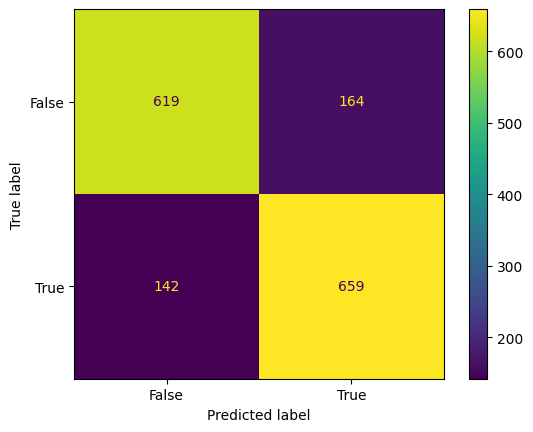

In [ ]:
# Confusion matrix of Results from Decision Tree classification
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, model.predict(x_test))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
											display_labels=[False, True])

cm_display.plot()
plt.show()
